In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy 
import random
import shutil, sys
import pandas as pd

plt.ion()

In [11]:
#data augmentation apenas para o treinamento
#normalization para a validaa

data_transforms = {'train': transforms.Compose(
                    [transforms.RandomResizedCrop(224),
                    #transforms.RandomRotation(degrees=(-10, 10)),
                    transforms.ColorJitter(brightness=.02),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                    ]),
                    'val': transforms.Compose([transforms.Resize(256),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                    ])
                  }

In [12]:

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [13]:
# Path to data
data_dir = '/home/jimi/dissertacao/covid19/datasets/dataset_original/'
train_dir = data_dir+'train/'
test_dir = data_dir+'test/'
val_dir = data_dir+'val/'

normal_dir = data_dir+'normal/'
pneumonia_dir = data_dir+'pneumonia/'
covid_dir = data_dir+'covid/'

len_covid = len([iq for iq in os.scandir(normal_dir)])
len_normal = len([iq for iq in os.scandir(pneumonia_dir)])
len_pneumonia = len([iq for iq in os.scandir(covid_dir)])

print('Files per classes')
print("----"*10)
print("normal : ", len_covid)
print("pneumonia : ", len_normal)
print("covid : ", len_pneumonia)


Files per classes
----------------------------------------
normal :  1341
pneumonia :  1345
covid :  505


In [14]:
# Load Kaggle Pneumonia Dataset
def get_dataset(path, label):
  return [[path+x, label] for x in os.listdir(path) if not x.startswith('.')]

#def split_dataset():
#path_drive = '/content/drive/My Drive/UNICAMP/databases/covid19/'
root = data_dir
normal_dir = data_dir+'normal/'
pneumonia_dir = data_dir+'pneumonia/'
covid_dir = data_dir+'covid/'

normal_xray = get_dataset(normal_dir, 'normal')
pneumonia_xray = get_dataset(pneumonia_dir, 'pneumonia')

#print(len(normal_xray), normal_xray[0:5])
#print(len(pneumonia_xray), pneumonia_xray[0:5])

# Load Covid-19 Dataset
# metadata_path='/content/drive/My Drive/UNICAMP/databases/covid19_v2/covid-chestxray-dataset/metadata.csv'
# srcpath = '/content/drive/My Drive/UNICAMP/databases/covid19_v2/covid-chestxray-dataset/images/'
# df=pd.read_csv(metadata_path)
# covid_patients=df['finding']=='COVID-19'
# PA=df['view']=='PA'
# PA_covid=df[covid_patients & PA]
covid_xray = get_dataset(covid_dir, 'covid')
#print(len(covid_xray), covid_xray[0:5])

random.shuffle(normal_xray)
random.shuffle(pneumonia_xray)
random.shuffle(covid_xray)

# gerando dados balanceados e randomizados
print("min_size = {}".format(min(len(normal_xray), len(pneumonia_xray), len(covid_xray))-1))
min_size = min(len(normal_xray), len(pneumonia_xray), len(covid_xray)) -1
dataset = normal_xray + pneumonia_xray + covid_xray
random.shuffle(dataset)

#print(len(dataset), dataset[0:5])

# carregando os dados para um df pandas
df = pd.DataFrame(dataset, columns=['X', 'y']).sample(frac=1)
#print(df)

X = df['X']
y = df['y']

print (X)
X.shape
print('----------')
print (y)
y.shape

classes= y.unique()
print("Classes: {}".format(classes))

# Split em train, val, e test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42) #pega % do treino e separa para teste/
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42) #pega % do treino e separa para teste

print("-----"*10)
print("Total de imagens= {}, \nDados para: treino= {}, \nValidação= {} \nTeste= {} ".format(len(df), len(X_train), len(X_val), len(X_test)))
print("-----"*10)
print("Total Y= {}, \nDados para: Treino= {}, \nValidação= {} \nTeste= {} ".format(len(df), len(y_train), len(y_val), len(y_test)))

#cria uma nova pasta com as duas bases de dados agrupadas
for dtype, dinputs, doutputs in [['train', X_train, y_train], ['val', X_val, y_val], ['test', X_test, y_test]]:
  for _X, _y in zip(dinputs, doutputs):
    path = root+dtype+'/'+_y
    os.makedirs(path, exist_ok=True)
    print(_X, path)
    shutil.copy(_X, path)

  #!tar -czf dataset.tar.gz dataset/ #guarda toda a base obtida em um arquivo zip


min_size = 504
610     /home/jimi/dissertacao/covid19/datasets/datase...
2809    /home/jimi/dissertacao/covid19/datasets/datase...
2663    /home/jimi/dissertacao/covid19/datasets/datase...
2282    /home/jimi/dissertacao/covid19/datasets/datase...
792     /home/jimi/dissertacao/covid19/datasets/datase...
                              ...                        
230     /home/jimi/dissertacao/covid19/datasets/datase...
1088    /home/jimi/dissertacao/covid19/datasets/datase...
2350    /home/jimi/dissertacao/covid19/datasets/datase...
1707    /home/jimi/dissertacao/covid19/datasets/datase...
1317    /home/jimi/dissertacao/covid19/datasets/datase...
Name: X, Length: 3191, dtype: object
----------
610     pneumonia
2809    pneumonia
2663    pneumonia
2282       normal
792        normal
          ...    
230        normal
1088    pneumonia
2350    pneumonia
1707       normal
1317       normal
Name: y, Length: 3191, dtype: object
Classes: ['pneumonia' 'normal' 'covid']
------------------------

/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (914).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (799).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/447.png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (90).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (637).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (998).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (154)

/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (558).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (381).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (117).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (562).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1119).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1282).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/disser

/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (195).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1327).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (742).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (34).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/42.jpg /home/jimi/dissertacao/covid19/datasets/dataset_original/train/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/322.png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (420).png /home/

/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (98).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (716).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (501).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1227).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/40.jpeg /home/jimi/dissertacao/covid19/datasets/dataset_original/train/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (737).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/datas

/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (1213).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (768).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (516).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (818).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/110.jpg /home/jimi/dissertacao/covid19/datasets/dataset_original/train/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (40).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1322).

/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1232).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (699).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (500).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (37).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/168.jpeg /home/jimi/dissertacao/covid19/datasets/dataset_original/train/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (863).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid1

/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (277).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (475).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (983).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (84).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (214).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1328).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/hom

/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (931).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (778).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (66).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/428.png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (517).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (323).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/datase

/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/432.png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (73).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (265).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (1198).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1031).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (1197).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/p

/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (557).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (1058).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/140.jpeg /home/jimi/dissertacao/covid19/datasets/dataset_original/train/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1155).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (1066).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (290).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Vira

/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/128.jpg /home/jimi/dissertacao/covid19/datasets/dataset_original/train/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (743).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/185.jpg /home/jimi/dissertacao/covid19/datasets/dataset_original/train/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (36).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1143).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (249).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL 

/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (1045).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (412).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (417).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/227.jpg /home/jimi/dissertacao/covid19/datasets/dataset_original/train/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/430.png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (758).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (114).png /home/jimi/disserta

/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (276).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/385.png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (425).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (98).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (285).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (18).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/norma

/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (1175).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (306).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (567).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (517).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (570).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (794).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/

/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (226).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1075).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (564).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/300.jpg /home/jimi/dissertacao/covid19/datasets/dataset_original/train/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (411).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (113).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral P

/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (529).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (1282).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (234).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1067).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (129).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/451.png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (1118).png /home/

/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/173.jpg /home/jimi/dissertacao/covid19/datasets/dataset_original/train/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (793).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (927).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1248).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (281).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (479).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pn

/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (1304).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (1176).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (77).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1261).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (732).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (232).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/norma

/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (1109).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (125).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (907).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (627).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (1268).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (604).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneu

/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (515).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (938).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (45).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (1033).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (74).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (731).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/N

/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/337.png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (492).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1289).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/194.jpg /home/jimi/dissertacao/covid19/datasets/dataset_original/train/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (1243).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1202).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia 

/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/255.jpeg /home/jimi/dissertacao/covid19/datasets/dataset_original/train/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (1011).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (870).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (714).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (735).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (276).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (1309).png /home/

/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1140).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1193).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (909).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (180).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (478).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/357.png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/c

/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (865).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/195.jpg /home/jimi/dissertacao/covid19/datasets/dataset_original/train/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/452.png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (445).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (1158).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (766).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (794).png /home/jimi/disserta

/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (696).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (1061).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (1012).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/431.png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1002).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (27).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/459.png /home/jimi/disser

/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/39.jpeg /home/jimi/dissertacao/covid19/datasets/dataset_original/train/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/302.jpg /home/jimi/dissertacao/covid19/datasets/dataset_original/train/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (703).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (53).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (271).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (1134).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (982).png /home/jimi/dissertac

/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (378).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (910).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (220).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (441).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (22).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (646).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/data

/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (1283).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (262).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (994).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/445.png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (919).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (141).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral P

/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (16).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1302).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (1281).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1097).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/66.jpeg /home/jimi/dissertacao/covid19/datasets/dataset_original/train/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (941).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/p

/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (707).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/484.png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (402).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (1290).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (673).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (280).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1206).png /home/jimi

/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (305).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (958).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (1090).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (365).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (951).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/43.jpg /home/jimi/dissertacao/covid19/datasets/dataset_original/train/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/pne

/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1085).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (99).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1045).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (589).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (853).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (832).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_

/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/261.png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (114).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (135).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1014).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1309).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (465).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/c

/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (133).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (688).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (145).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (515).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/159.jpg /home/jimi/dissertacao/covid19/datasets/dataset_original/train/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (752).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pne

/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (750).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (1069).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (356).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (486).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (359).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1150).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset

/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (1010).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (1177).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (95).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (918).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/287.jpg /home/jimi/dissertacao/covid19/datasets/dataset_original/train/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1006).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral 

/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (480).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (834).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (579).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (343).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (84).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/265.jpeg /home/jimi/dissertacao/covid19/datasets/dataset_original/train/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/pne

/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/174.jpg /home/jimi/dissertacao/covid19/datasets/dataset_original/train/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (354).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (1313).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (518).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (655).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1156).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/249.jpeg /

/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (368).png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (713).png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (612).png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (28).png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/444.png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/361.png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (700).png /home/

/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/371.png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (213).png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (720).png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1026).png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (17).png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (375).png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (

/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (811).png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (908).png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (111).png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/301.jpg /home/jimi/dissertacao/covid19/datasets/dataset_original/val/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (833).png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/119.jpg /home/jimi/dissertacao/covid19/datasets/dataset_original/val/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia 

/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (769).png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (170).png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (1094).png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (652).png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (842).png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (993).png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pn

/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1063).png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (560).png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (554).png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (966).png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (70).png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1334).png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/nor

/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (447).png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (1037).png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (847).png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (657).png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (788).png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (815).png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/cov

/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (740).png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (1333).png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/464.png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (793).png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1297).png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (724).png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Vir

/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (134).png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/405.png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (1119).png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (210).png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/273.jpg /home/jimi/dissertacao/covid19/datasets/dataset_original/val/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (887).png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1132).png /ho

/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (965).png /home/jimi/dissertacao/covid19/datasets/dataset_original/test/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/314.png /home/jimi/dissertacao/covid19/datasets/dataset_original/test/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (410).png /home/jimi/dissertacao/covid19/datasets/dataset_original/test/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/475.png /home/jimi/dissertacao/covid19/datasets/dataset_original/test/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (228).png /home/jimi/dissertacao/covid19/datasets/dataset_original/test/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (453).png /home/jimi/dissertacao/covid19/datasets/dataset_original/test/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (434).png /home/jimi/dissertacao/cov

In [15]:
def imshow(inp, title=None):
    """Imshow for tensor"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pausa um pouco para que os gráficos sejam atualizados

In [16]:
#pega o batch de treinamento
inputs, classes = next(iter(dataloaders['train']))

In [17]:
#grid from batch
out = torchvision.utils.make_grid(inputs)

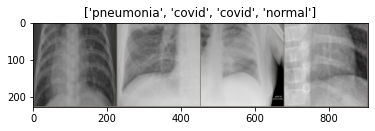

In [18]:
imshow(out, title=[class_names[x] for x in classes])

In [19]:
#traing
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range (num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs -1))
        print('-'*20)
        
        #cada epoca tem uma fase de treino e validação
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() #seta o moledo para treinar
            else:
                model.eval() #seta para validação
                
            running_loss = 0.0
            running_corrects = 0
            
            # Itera sobre os dados
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                #zero gradientes
                optimizer.zero_grad()
                
                #forward
                #rastrea o historico se apenas no treino
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    #backward + optimizer only se estiver no treino
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                        
                #statistc
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()
                
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            #copia para o modelo
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    #carrega o modelo com os melhores pesos
    model.load_state_dict(best_model_wts)
    
    return model

In [20]:
# Função genérica para mostrar as predições das imagens
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far +=1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
                
        model.train(mode=was_training)

In [74]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Sequential(nn.Linear(num_ftrs, 1024),
                              nn.ReLU(),
                              nn.Dropout(0.5),
                              nn.Linear(1024, 3),
                              nn.Softmax(dim=1))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [75]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=50)

Epoch 0/49
--------------------
train Loss: 0.9414 Acc: 0.6051
val Loss: 0.8184 Acc: 0.7362

Epoch 1/49
--------------------
train Loss: 0.8872 Acc: 0.6618
val Loss: 0.7718 Acc: 0.7796

Epoch 2/49
--------------------
train Loss: 0.8788 Acc: 0.6656
val Loss: 0.7769 Acc: 0.7809

Epoch 3/49
--------------------
train Loss: 0.8868 Acc: 0.6567
val Loss: 0.7658 Acc: 0.7871

Epoch 4/49
--------------------
train Loss: 0.8778 Acc: 0.6631
val Loss: 0.7789 Acc: 0.7697

Epoch 5/49
--------------------
train Loss: 0.8661 Acc: 0.6755
val Loss: 0.7703 Acc: 0.7741

Epoch 6/49
--------------------
train Loss: 0.8623 Acc: 0.6850
val Loss: 0.7116 Acc: 0.8361

Epoch 7/49
--------------------
train Loss: 0.8220 Acc: 0.7290
val Loss: 0.7103 Acc: 0.8330

Epoch 8/49
--------------------
train Loss: 0.8269 Acc: 0.7232
val Loss: 0.6859 Acc: 0.8808

Epoch 9/49
--------------------
train Loss: 0.8055 Acc: 0.7522
val Loss: 0.6673 Acc: 0.8939

Epoch 10/49
--------------------
train Loss: 0.8044 Acc: 0.7503
val Lo

In [21]:
model_conv = torchvision.models.densenet121(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = True

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.classifier.in_features
model_conv.classifier.in_features = (nn.Linear(num_ftrs, 1024),
                                      nn.ReLU(),
                                      nn.Dropout(0.5),
                                      nn.Linear(1024, 3),
                                      nn.Softmax(dim=1))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.classifier.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [22]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=50)

Epoch 0/49
--------------------
train Loss: 0.9847 Acc: 0.6403
val Loss: 0.3643 Acc: 0.8815

Epoch 1/49
--------------------
train Loss: 0.6614 Acc: 0.7413
val Loss: 0.3139 Acc: 0.8935

Epoch 2/49
--------------------
train Loss: 0.6290 Acc: 0.7555
val Loss: 0.2655 Acc: 0.9222

Epoch 3/49
--------------------
train Loss: 0.6070 Acc: 0.7577
val Loss: 0.2529 Acc: 0.9232

Epoch 4/49
--------------------
train Loss: 0.6355 Acc: 0.7609
val Loss: 0.4365 Acc: 0.8538

Epoch 5/49
--------------------
train Loss: 0.6824 Acc: 0.7404
val Loss: 0.2529 Acc: 0.9279

Epoch 6/49
--------------------


OSError: Caught OSError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/jimi/.local/lib/python3.7/site-packages/PIL/ImageFile.py", line 233, in load
    s = read(self.decodermaxblock)
  File "/home/jimi/.local/lib/python3.7/site-packages/PIL/PngImagePlugin.py", line 838, in load_read
    cid, pos, length = self.png.read()
  File "/home/jimi/.local/lib/python3.7/site-packages/PIL/PngImagePlugin.py", line 129, in read
    length = i32(s)
  File "/home/jimi/.local/lib/python3.7/site-packages/PIL/_binary.py", line 71, in i32be
    return unpack_from(">I", c, o)[0]
struct.error: unpack_from requires a buffer of at least 4 bytes

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/jimi/.local/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/jimi/.local/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/jimi/.local/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/jimi/.local/lib/python3.7/site-packages/torchvision/datasets/folder.py", line 135, in __getitem__
    sample = self.loader(path)
  File "/home/jimi/.local/lib/python3.7/site-packages/torchvision/datasets/folder.py", line 171, in default_loader
    return pil_loader(path)
  File "/home/jimi/.local/lib/python3.7/site-packages/torchvision/datasets/folder.py", line 154, in pil_loader
    return img.convert('RGB')
  File "/home/jimi/.local/lib/python3.7/site-packages/PIL/Image.py", line 901, in convert
    self.load()
  File "/home/jimi/.local/lib/python3.7/site-packages/PIL/ImageFile.py", line 239, in load
    raise OSError("image file is truncated")
OSError: image file is truncated


In [ ]:
model_conv = torchvision.models.densenet201(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = True

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.classifier.in_features
model_conv.classifier.in_features = (nn.Linear(num_ftrs, 1024),
                                      nn.ReLU(),
                                      nn.Dropout(0.5),
                                      nn.Linear(1024, 3),
                                      nn.Softmax(dim=1))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.classifier.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=100)

In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Sequential(nn.Linear(num_ftrs, 1024),
                              nn.ReLU(),
                              nn.Dropout(0.5),
                              nn.Linear(1024, 3),
                              nn.Softmax(dim=1))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=100)

In [ ]:
model_conv = torchvision.models.densenet121(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = True

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.classifier.in_features
model_conv.classifier.in_features = (nn.Linear(num_ftrs, 1024),
                                      nn.ReLU(),
                                      nn.Dropout(0.5),
                                      nn.Linear(1024, 3),
                                      nn.Softmax(dim=1))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.classifier.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=100)

In [ ]:
model_conv = torchvision.models.densenet201(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = True

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.classifier.in_features
model_conv.classifier.in_features = (nn.Linear(num_ftrs, 256),
                                      nn.ReLU(),
                                      nn.Dropout(0.5),
                                      nn.Linear(256, 3),
                                      nn.Softmax(dim=1))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.classifier.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=100)

In [ ]:
model_conv = torchvision.models.densenet201(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = True

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.classifier.in_features
model_conv.classifier.in_features = (nn.Linear(num_ftrs, 64),
                                      nn.ReLU(),
                                      nn.Dropout(0.3),
                                      nn.Linear(64, 3),
                                      nn.Softmax(dim=1))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.classifier.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=100)

In [83]:
model_conv = torchvision.models.densenet121(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = True

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.classifier.in_features
model_conv.classifier.in_features = (nn.Linear(num_ftrs, 1024),
                                            nn.ReLU(),
                                            nn.Linear(num_ftrs, 512),
                                            nn.ReLU(),
                                            nn.Linear(num_ftrs, 256),
                                            nn.ReLU(),
                                            nn.Dropout(0.5),
                                            nn.Linear(num_ftrs, 128),
                                            nn.ReLU(),
                                            nn.Linear(num_ftrs, 32),
                                            nn.ReLU(),
                                            nn.Dropout(0.5),
                                            nn.Linear(32, 3),
                                            nn.Softmax(dim=1))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.classifier.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=100)

Epoch 0/49
--------------------
train Loss: 0.9012 Acc: 0.6573
val Loss: 0.3145 Acc: 0.8982

Epoch 1/49
--------------------
train Loss: 0.6834 Acc: 0.7350
val Loss: 0.3221 Acc: 0.8945

Epoch 2/49
--------------------
train Loss: 0.5862 Acc: 0.7694
val Loss: 0.2980 Acc: 0.9038

Epoch 3/49
--------------------
train Loss: 0.6373 Acc: 0.7634
val Loss: 0.3518 Acc: 0.8908

Epoch 4/49
--------------------
train Loss: 0.6385 Acc: 0.7672
val Loss: 0.2679 Acc: 0.9218

Epoch 5/49
--------------------
train Loss: 0.5990 Acc: 0.7771
val Loss: 0.3121 Acc: 0.8883

Epoch 6/49
--------------------
train Loss: 0.6287 Acc: 0.7548
val Loss: 0.3806 Acc: 0.8392

Epoch 7/49
--------------------
train Loss: 0.5202 Acc: 0.8061
val Loss: 0.2227 Acc: 0.9205

Epoch 8/49
--------------------
train Loss: 0.4896 Acc: 0.8057
val Loss: 0.2409 Acc: 0.9280

Epoch 9/49
--------------------
train Loss: 0.4693 Acc: 0.8038
val Loss: 0.2218 Acc: 0.9317

Epoch 10/49
--------------------
train Loss: 0.4873 Acc: 0.8080
val Lo